# 18기 Time Series 정규세션 과제

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.
데이터셋 출처 :  https://www.kaggle.com/datasets/shenba/time-series-datasets

### Box-Jenkins 방법론
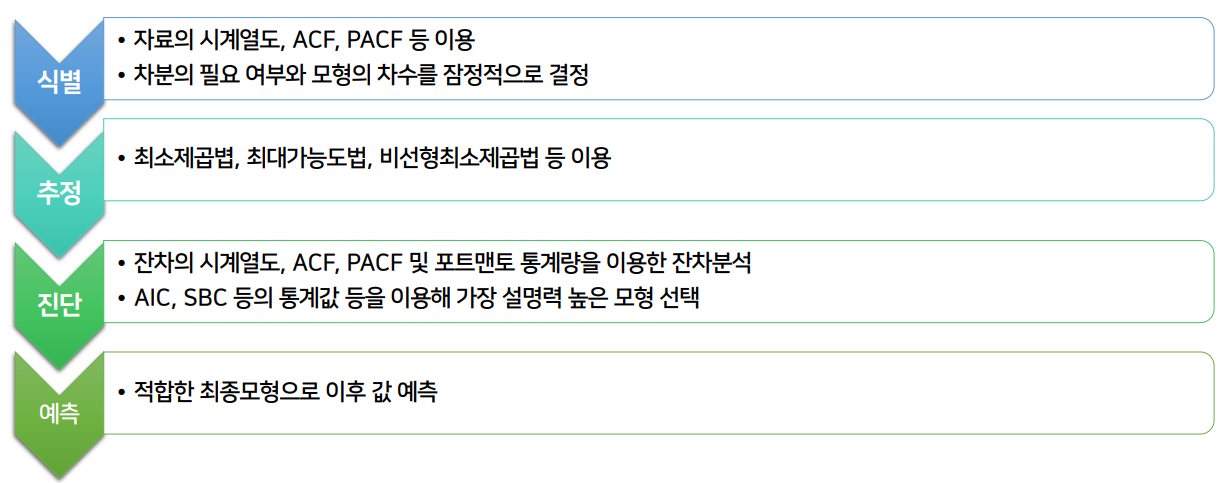
대략적 흐름 예시를 확인하고 싶다면 첨부한 '시계열자료_참고자료.pdf'를 읽어주세요.

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 데이터 불러오기

In [2]:
df = pd.read_csv('./Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


## 시계열 분해

### 데이터 타입 확인

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [4]:
# object를 datetype 형태로 변환
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace = True)
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### 원본데이터 추세 확인

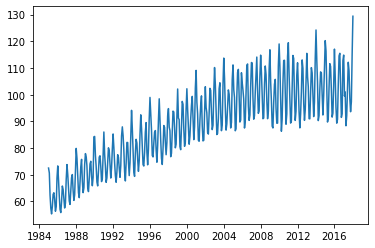

In [5]:
plt.plot(df.index, df['IPG2211A2N'])
plt.show()

### 시계열 분해

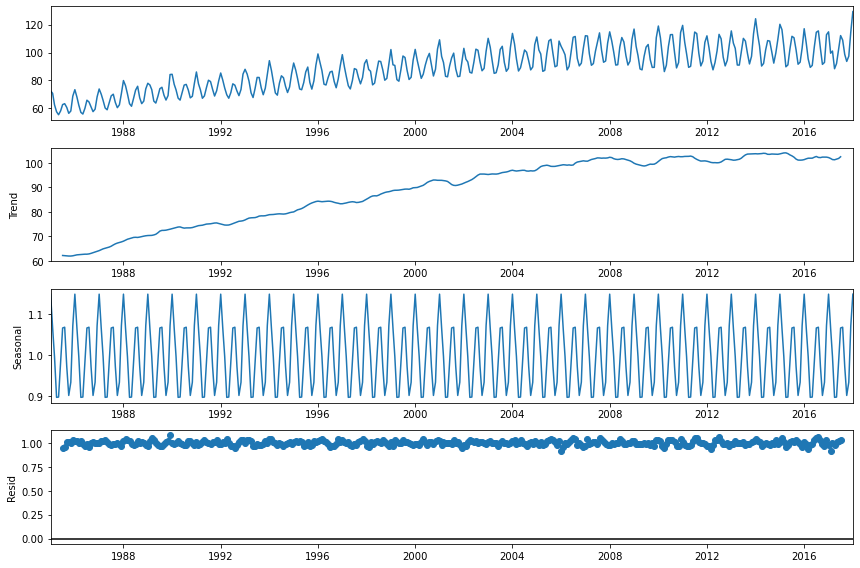

In [6]:
# 시계열 분해 결과 Trend와 Seasonal이 존재
ts = df
result = seasonal_decompose(ts, model = 'multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()

In [7]:
df.shape

(397, 1)

## 정상성 변환

In [8]:
# 우상향 트렌드를 보였기 때문에 ct값을 적용하여 regression 검정 결과 p-value가 0.05보다 높기 때문에 정상성을 가지지 않음
# 비정상 시계열을 정상 시계열로 변환하기 위하여 1차차분 또는 로그변환을 적용
train = df[:"2014-12-01"]
test = df.drop(train.index)

adf = adfuller(train, regression = 'ct')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: -1.433644734975069
p-value: 0.8507636188291595


<AxesSubplot:xlabel='DATE'>

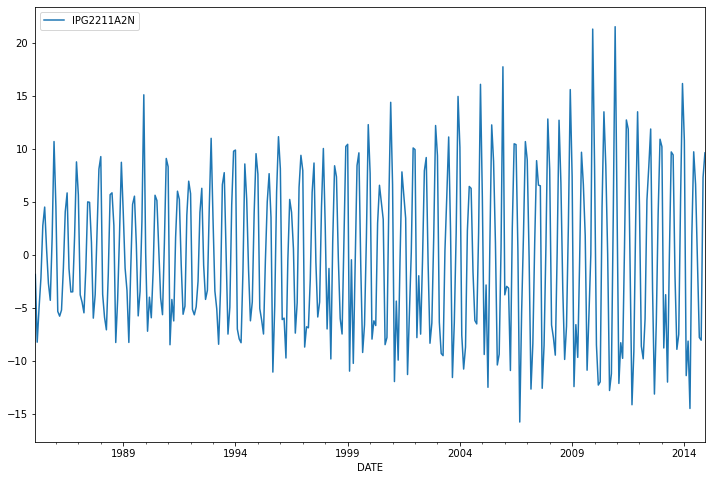

In [9]:
diff_df = train.diff(1)
diff_df = diff_df.dropna()
diff_df.plot()

In [10]:
# adfuller의 regression default 값은 'c', 1차 차분한 그래프가 트렌드를 보이지 않기 때문에 매개변수 'c'를 사용하여 검정
# p-value 값이 0.05보다 작으므로 귀무가설 기각, 정상시계열로 변환                                                 
adf = adfuller(diff_df)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')

ADF Statistic: -6.915049065980454
p-value: 1.1853567881008217e-09


## AR 모형과 MA 모형

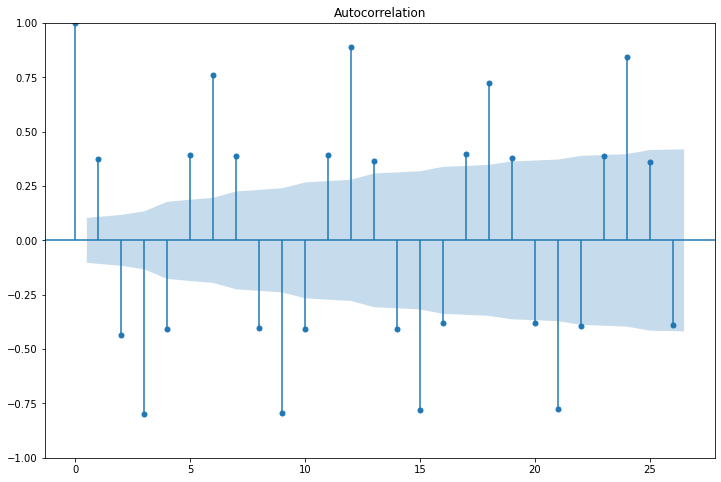

In [11]:
# AR 모형의 p값 탐색
plot_acf(diff_df)
plt.show()

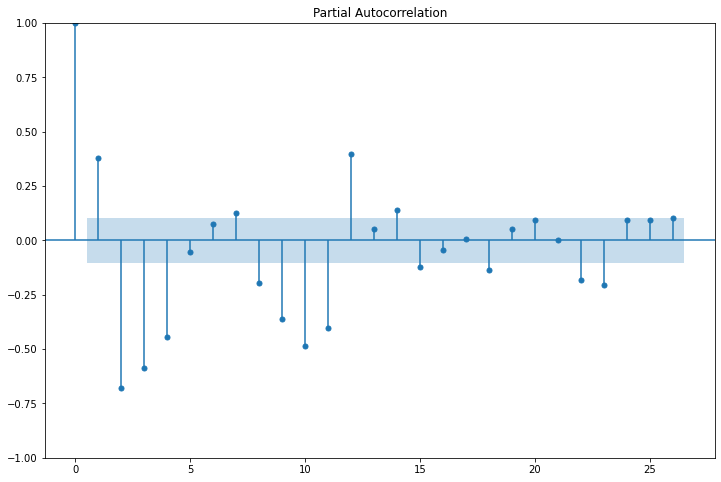

In [12]:
# AR 모형의 q값 탐색
plot_pacf(diff_df)
plt.show()

In [16]:
model = ARIMA(train, order = (2,1,2), trend = 't')
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             IPG2211A2N   No. Observations:                  360
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -934.188
Date:                Mon, 22 Aug 2022   AIC                           1880.376
Time:                        16:18:36   BIC                           1903.676
Sample:                    01-01-1985   HQIC                          1889.641
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1049      0.165      0.637      0.524      -0.218       0.428
ar.L1          0.9995      0.001    770.964      0.000       0.997       1.002
ar.L2         -0.9996      0.001  -1283.790      0.000      -1.001      -0.998
ma.L1         -1.0466      0.017    -63.130      0.000      -1.079      -1.014
ma.L2          0.9940      0.026     38.691      0.000       0.944       1.044
sigma2        10.3232      0.676     15.265      0.000       8.998      11.649
===================================================================================
Ljung-Box (L1) (Q):                   5.18   Jarque-Bera (JB):                 7.34
Prob(Q):                              0.02   Prob(JB):                         0.03
Heteroskedasticity (H):               2.20   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

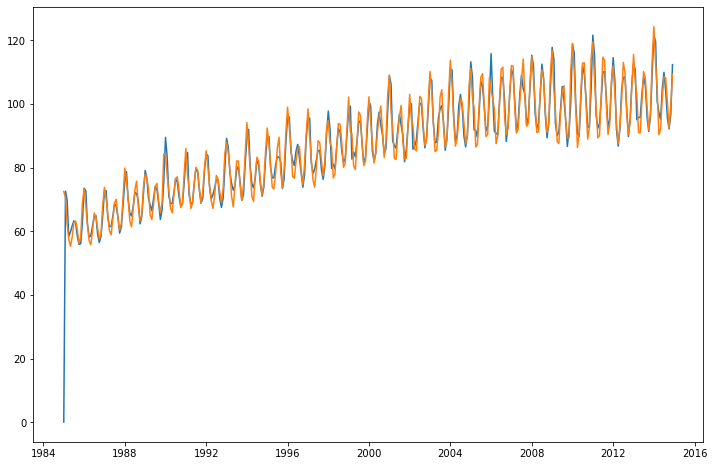

In [17]:
plt.plot(res.predict())
plt.plot(train)

In [18]:
forecast_data = res.forecast(steps = len(test), alpha = 0.05)

pred_y = forecast_data
pred_y

2015-01-01    117.799083
2015-02-01    113.751507
2015-03-01    101.362708
2015-04-01     93.130496
2015-05-01     97.390789
2015-06-01    109.982850
2015-07-01    118.415324
2015-08-01    114.361746
2015-09-01    101.985850
2015-10-01     93.772534
2015-11-01     98.038817
2015-12-01    110.617976
2016-01-01    119.031567
2016-02-01    114.972011
2016-03-01    102.609016
2016-04-01     94.414569
2016-05-01     98.686818
2016-06-01    111.253077
2016-07-01    119.647813
2016-08-01    115.582304
2016-09-01    103.232206
2016-10-01     95.056602
2016-11-01     99.334792
2016-12-01    111.888155
2017-01-01    120.264061
2017-02-01    116.192622
2017-03-01    103.855420
2017-04-01     95.698633
2017-05-01     99.982740
2017-06-01    112.523209
2017-07-01    120.880311
2017-08-01    116.802968
2017-09-01    104.478658
2017-10-01     96.340661
2017-11-01    100.630661
2017-12-01    113.158239
2018-01-01    121.496564
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
test_y = test
test_y.head()

,IPG2211A2N
DATE,
2015-01-01,120.2696
2015-02-01,116.3788
2015-03-01,104.4706
2015-04-01,89.7461
2015-05-01,91.0930


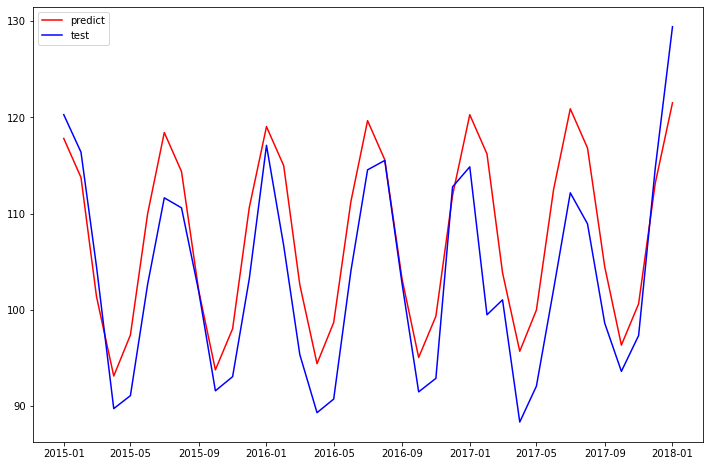

In [21]:
plt.plot(pred_y, color = 'red', label = 'predict')
plt.plot(test_y, color = 'blue', label = 'test')
plt.legend()
plt.show()

In [22]:
print(f'R2_score: {r2_score(test_y, pred_y)}')
RMSE = mean_squared_error(test_y, pred_y) ** 0.5
print(f'RMSE: {RMSE}')

R2_score: 0.6432399479823622
RMSE: 6.185819966837108


In [24]:
auto_model = auto_arima(train, start_p=0, d=1, start_q=0,
                       max_p=3, max_q=3, start_P=0, start_Q=0, max_P=3, max_Q=3, m=12,
                       seasonal=True, information_criterion='aic', trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2467.575, Time=0.17 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2142.450, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2465.642, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2350.615, Time=0.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1702.233, Time=2.46 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1808.493, Time=1.27 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=1703.064, Time=6.20 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1702.396, Time=4.44 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2060.697, Time=1.85 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=1765.797, Time=2.79 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=1702.338, Time=6.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1722.556, Time=1.35 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1645.156, Time=3.68 sec
 ARIMA(1,1,1)(0,0,1)[12]

In [25]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  360
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -815.023
Date:                              Mon, 22 Aug 2022   AIC                           1642.046
Time:                                      16:30:42   BIC                           1665.346
Sample:                                  01-01-1985   HQIC                          1651.311
                                       - 12-01-2014                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3673      0.102      3.606      0.000       0.168       0.567
ma.L1         -0.7408      0.107     -6.929      0.000      -0.950      -0.531
ma.L2         -0.1970      0.095     -2.076      0.038      -0.383      -0.011
ar.S.L12       0.9948      0.004    251.209      0.000       0.987       1.003
ma.S.L12      -0.7278      0.043    -16.789      0.000      -0.813      -0.643
sigma2         4.9956      0.306     16.334      0.000       4.396       5.595
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                24.93
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
auto_pred_y = pd.DataFrame(auto_model.predict(n_preiods = len(test)), index = test.index)
auto_pred_y.columns = ['predicted_price']
auto_pred_y.head()

,predicted_price
DATE,
2015-01-01,117.627438
2015-02-01,109.200826
2015-03-01,102.060851
2015-04-01,91.319851
2015-05-01,93.096714


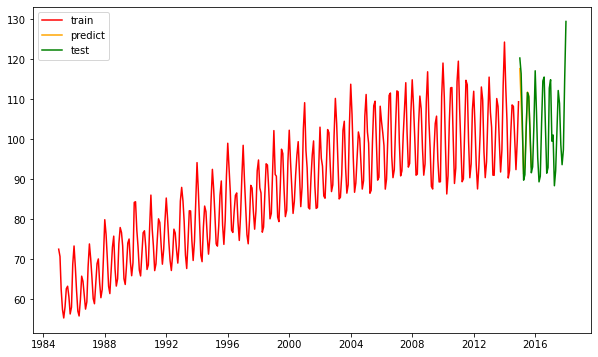

In [48]:
plt.figure(figsize=(10,6))
plt.plot(train, color = 'red', label = 'train')
plt.plot(auto_pred_y, color = 'orange', label = 'predict')
plt.plot(test, color = 'green', label = 'test')
plt.legend()
plt.show()